# Spin Qubits

These examples all cover dyanamical simulation of spin qubits. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000).

## Silicon Spin Qubit

This example demonstrates simulation of an electrically-driven silicon spin qubit taken from ["Nonlinear Response and Crosstalk of Electrically Driven Silicon Spin Qubits"](https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.19.044078)

In [3]:
import cudaq
from cudaq import spin, boson, Schedule, ScalarOperator, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

dimensions = {0: 2}
resonance_frequency = 2 * np.pi * 10  # 10 Ghz

# Run the simulation:
evolution_results = []
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
# Sweep the amplitude
amplitudes = np.linspace(0.0, 0.5, 20)
for amplitude in amplitudes:
    rho0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))
    t_final = 100
    dt = 0.005
    n_steps = int(np.ceil(t_final / dt)) + 1
    steps = np.linspace(0, t_final, n_steps)
    schedule = Schedule(steps, ["t"])
    # Electric dipole spin resonance (`EDSR`) Hamiltonian
    H = 0.5 * resonance_frequency * spin.z(0) + ScalarOperator(
        lambda t: 0.5 * np.sin(resonance_frequency * t) * amplitude) * spin.x(0)
    evolution_result = cudaq.evolve(H,
                                    dimensions,
                                    schedule,
                                    rho0,
                                    observables=[boson.number(0)],
                                    collapse_operators=[],
                                    store_intermediate_results=True,
                                    integrator=ScipyZvodeIntegrator())
    evolution_results.append(get_result(0, evolution_result))


print(evolution_results)

fig, ax = plt.subplots()
im = ax.contourf(steps, amplitudes, evolution_results)
ax.set_xlabel("Time (ns)")
ax.set_ylabel(f"Amplitude (a.u.)")
fig.suptitle(f"Excited state probability")
fig.colorbar(im)

KeyboardInterrupt: 

## Heisenberg Model

This example solves the [Quantum Heisenberg model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model),which exhibits the so-called quantum quench effect. See ["Quantum quenches in the anisotropic spin-1/2 Heisenberg chain: different approaches to many-body dynamics far from equilibrium"](https://iopscience.iop.org/article/10.1088/1367-2630/12/5/055017) for more details.

Text(0.5, 0, 'Time')

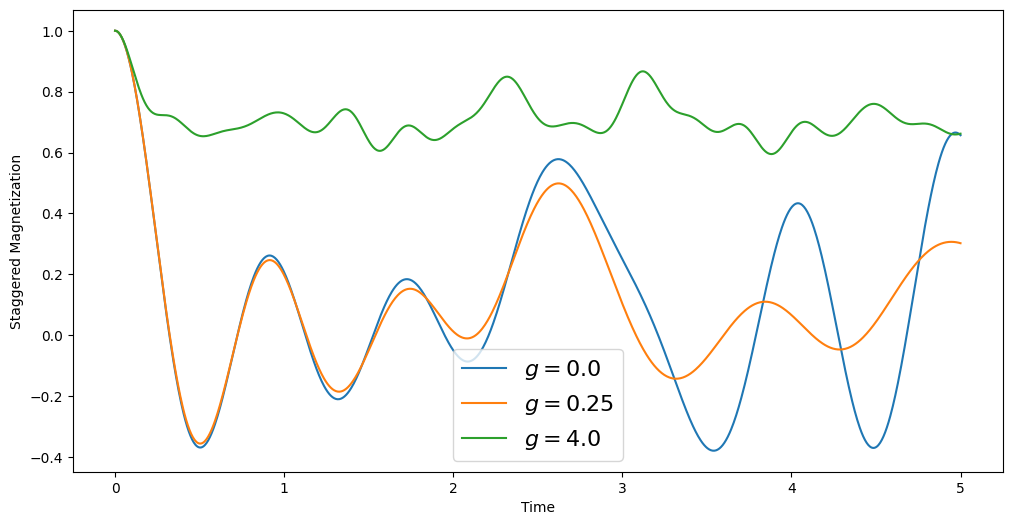

In [2]:
import cudaq
from cudaq import spin, Schedule, ScipyZvodeIntegrator

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Number of spins
N = 9
dimensions = {}
for i in range(N):
    dimensions[i] = 2

# Initial state: alternating spin up and down
spin_state = ''
for i in range(N):
    spin_state += str(int(i % 2))

# Observable is the staggered magnetization operator
staggered_magnetization_op = spin.empty()
for i in range(N):
    if i % 2 == 0:
        staggered_magnetization_op += spin.z(i)
    else:
        staggered_magnetization_op -= spin.z(i)

staggered_magnetization_op /= N

observe_results = []
for g in [0.0, 0.25, 4.0]:
    # Heisenberg model spin coupling strength
    Jx = 1.0
    Jy = 1.0
    Jz = g

    # Construct the Hamiltonian
    H = spin.empty()

    for i in range(N - 1):
        H += Jx * spin.x(i) * spin.x(i + 1)
        H += Jy * spin.y(i) * spin.y(i + 1)
        H += Jz * spin.z(i) * spin.z(i + 1)

    steps = np.linspace(0.0, 5, 1000)
    schedule = Schedule(steps, ["time"])

    # Prepare the initial state vector
    psi0_ = cp.zeros(2**N, dtype=cp.complex128)
    psi0_[int(spin_state, 2)] = 1.0
    psi0 = cudaq.State.from_data(psi0_)

    # Run the simulation
    evolution_result = cudaq.evolve(H,
                                    dimensions,
                                    schedule,
                                    psi0,
                                    observables=[staggered_magnetization_op],
                                    collapse_operators=[],
                                    store_intermediate_results=True,
                                    integrator=ScipyZvodeIntegrator())

    exp_val = [
        exp_vals[0].expectation()
        for exp_vals in evolution_result.expectation_values()
    ]

    observe_results.append((g, exp_val))

# Plot the results
fig = plt.figure(figsize=(12, 6))
for g, exp_val in observe_results:
    plt.plot(steps, exp_val, label=f'$ g = {g}$')
plt.legend(fontsize=16)
plt.ylabel("Staggered Magnetization")
plt.xlabel("Time")